In [628]:
#data manipulation packages
import pandas as pd
import numpy as np
from scipy import stats
import re

#visualization tools
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

### What exactly are we trying to predict?
We are trying for forecast sales for 28 forecast days. The sample submission has the following format:

The columns represent 28 forecast days. We will fill these forecast days with our predictions.
The rows each represent a specific item. This id tells us the item type, state, and store. We don't know what these items are exactly.

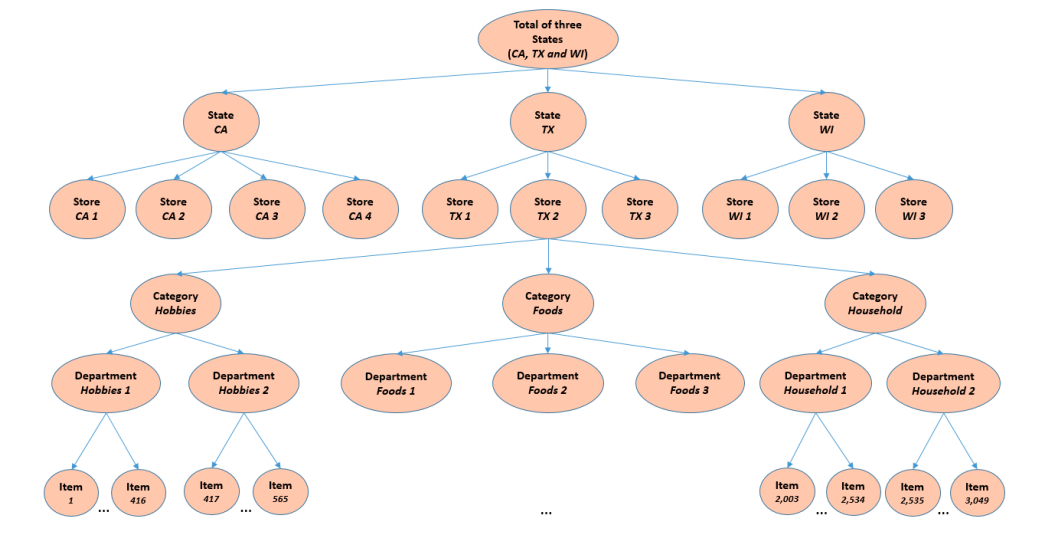

#### calendar.csv - Contains information about the dates on which the products are sold.
#### sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
#### sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
#### sell_prices.csv - Contains information about the price of the products sold per store and date.

In [17]:
cal = pd.read_csv('calendar.csv', parse_dates = ['date'])
sales = pd.read_csv('sales_train_validation.csv')
prices = pd.read_csv('sell_prices.csv')

print(cal.shape)
print(sales.shape)
print(prices.shape)

(1969, 14)
(30490, 1919)
(6841121, 4)


In [101]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [102]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [24]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,...,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


### Let's first explore the Sales Dataset

Since both Sales and Cal dataframes both share 'd_' values, let's merge them together so we can create an informed time series plot with actual date values.

In [315]:
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
d_cols = [col for col in sales.columns if 'd_' in col]

def plot_item(item_id):
    '''Plot the selling history of "item" by day, month, and year.
    
    Args:
        item(str): id of the item we are wanting to plot.
    
    Returns:
        matplotlib plot object of item sale history
    '''
    global item
    item = 'FOODS_3_090_CA_3'
    
    item_df = sales.loc[sales['id'] == item_id][d_cols].T
    item_df = item_df.rename(columns={sales.index[sales['id']==item_id].to_list()[0]:item_id}) # Name it correctly
    item_df = item_df.reset_index().rename(columns={'index': 'd'}) # make the index "d"
    item_df = item_df.merge(cal, how='left', validate='1:1')

    fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
    item_df[['date', item_id]].set_index('date').resample('D').mean()[item_id].plot(ax=axes, label='By day', alpha=0.8).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', item_id]].set_index('date').resample('M').mean()[item_id].plot(ax=axes, label='By month', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    item_df[['date', item_id]].set_index('date').resample('Y').mean()[item_id].plot(ax=axes, label='By year', alpha=1).set_ylabel('Amount of Item Sold', fontsize=14);
    axes.set_title('Mean '+str(item_id)+ ' sold by hour, day and month', fontsize=16);
    axes.legend()

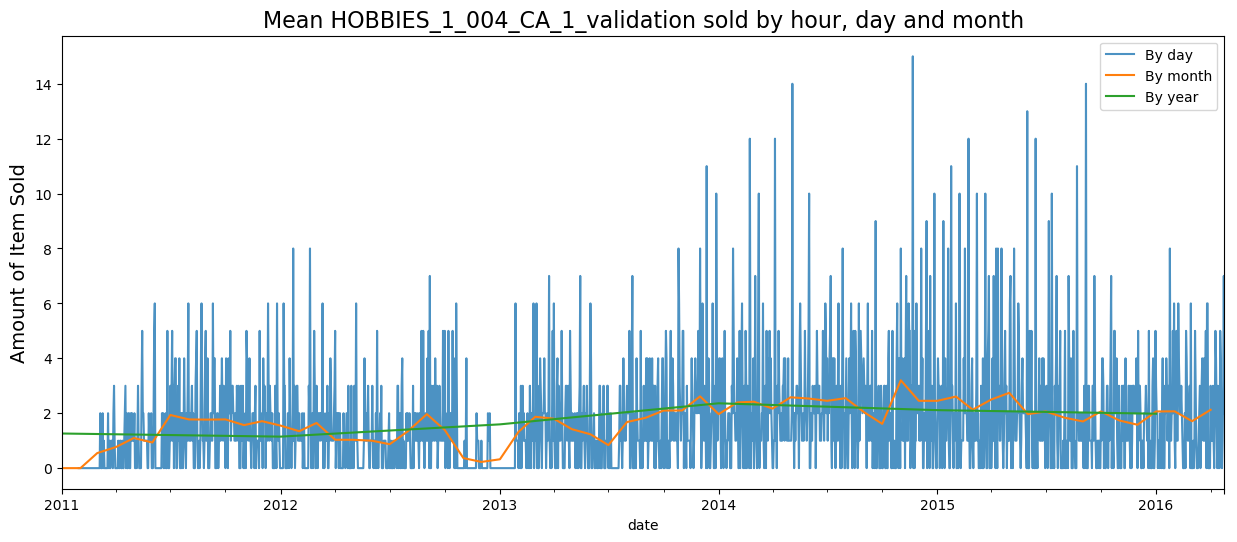

In [316]:
plot_item('HOBBIES_1_004_CA_1_validation')

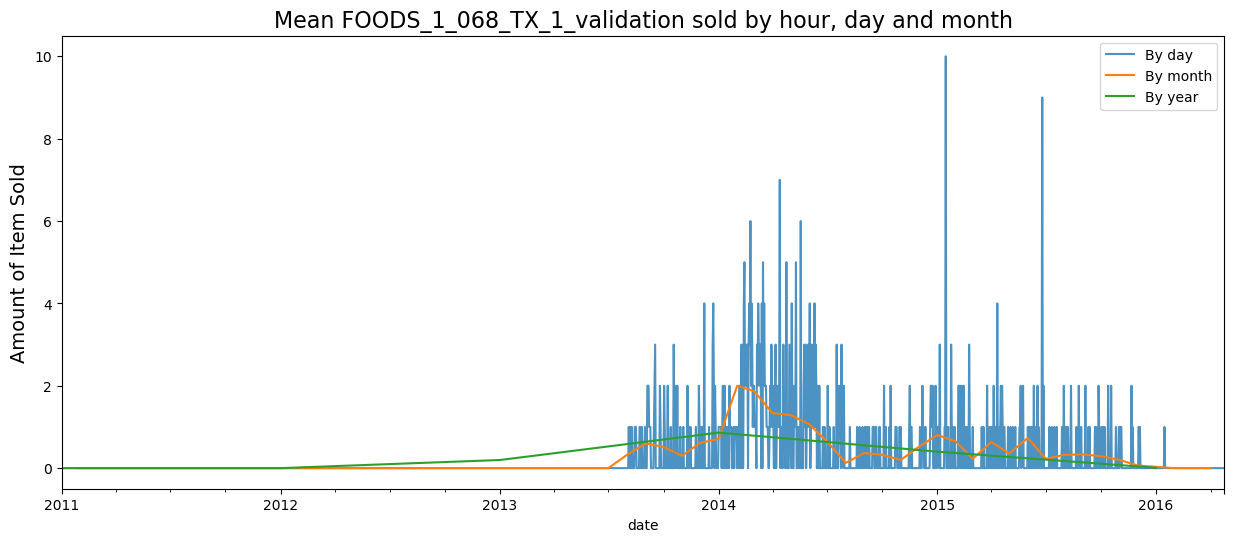

In [323]:
plot_item('FOODS_1_068_TX_1_validation')

We can see from some of our plots that some of the items weren't sold throughout the entire date range. We will need to fix this so our data isn't skewed.

In [372]:
'''As observed above, some of the items, for one reason or another, have limited history throughout the time series.
The following script will find the items that have limited history, the amount of consecutive zeros within the time
series, and where exactly they occur in the series (i.e. 'beginning', 'middle', 'end').
'''

import itertools

limited_items = {}

for item_id in sales['id']:
    df = sales.loc[sales['id'] == item_id][d_cols].T
    df = df.rename(columns={sales.index[sales['id']==item_id].to_list()[0]:item_id}) # Name it correctly
    df = df.reset_index().rename(columns={'index': 'd'}) # make the index "d"
    df = df.merge(cal, how='left', validate='1:1')
    
    rolled = np.asarray(df.iloc[:,1].astype(int))
    
    zero_consec, zero_count = [0], 0
    
    condition = np.where(rolled==0,'true','false')
    zero_groups = [ sum( 1 for _ in group ) for key, group in itertools.groupby( condition ) if key ]
    zero_gap = (zero_groups.index(max(zero_groups))/len(zero_groups))*100

    if zero_gap<35:
        zero_location = 'beginning'
    elif zero_gap <= 35 or zero_gap<=75:
        zero_location = 'middle'
    else:
        zero_location = 'end'

    for val in rolled:
        condition = val == 0
        if val==0:
            zero_count+=1
        else:
            if zero_count>zero_consec[0]:
                zero_consec[0] = zero_count
            else:
                zero_count = 0
    if zero_consec[0]>150:
        limited_items[item_id] = zero_consec[0], zero_location
    else:
        continue

In [398]:
print(dict(itertools.islice(limited_items.items(), 3)))

{'HOBBIES_1_001_CA_1_validation': (916, 'beginning'), 'HOBBIES_1_003_CA_1_validation': (1109, 'beginning'), 'HOBBIES_1_006_CA_1_validation': (429, 'beginning')}


In [394]:
print('The percentage of items that have more than 150 consecutive days without the item being sold is: {}'.format((len(limited_items)/sales.shape[0])*100))

The percentage of items that have more than 150 consecutive days without the item being sold is: 69.97704165300098


Almost 70% of all of the items have more than 150 days without being sold -- given the date range. From the graphs we've obeserved above, at least part of this could be explained by the fact that the item wan't being sold throughout the entire date range. Perhaps there are other reasons as well. Let's pump out a few more graphs so that we can better understand these gaps.

<BarContainer object of 3 artists>

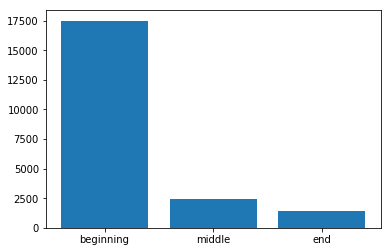

In [393]:
'''Plotting how much of the items with limited history occur in the beginning, middle, and end'''

from collections import Counter 

location = []
for key, value in limited_items.items():
    location.append(value[1])
    
totals = Counter(location)

plt.bar(totals.keys(), totals.values())

Based on the graph, an overwhelming amount of items having missing values in the beginning of the time series, though some zero gaps occur in the middle in the end.

Text(0, 0.5, 'Percentage of Nonzero')

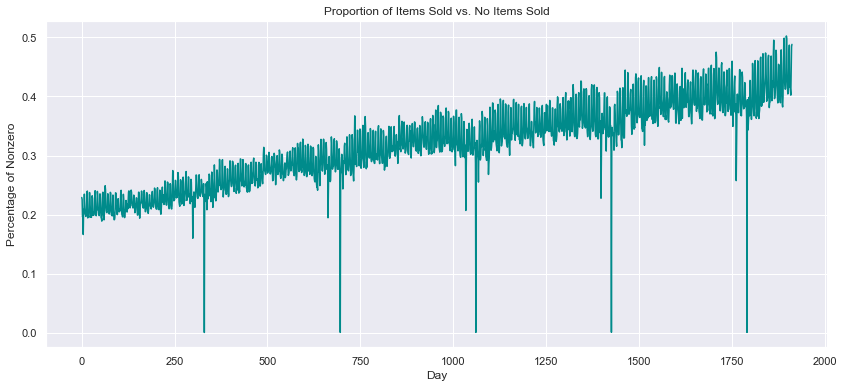

In [525]:
selling_history = sales[d_cols]

plt.figure(figsize = (14,6))
plt.plot((np.count_nonzero(selling_history.values, axis=0)/selling_history.shape[0]), color = 'darkcyan')
plt.title('Proportion of Items Sold vs. No Items Sold')
plt.xlabel('Day')
plt.ylabel('Percentage of Nonzero')

We can see that, as the time series progress, the percentage of items with non-zero days rises. This shows that there are a lot of items that aren't introduced from the beginning of the time series.

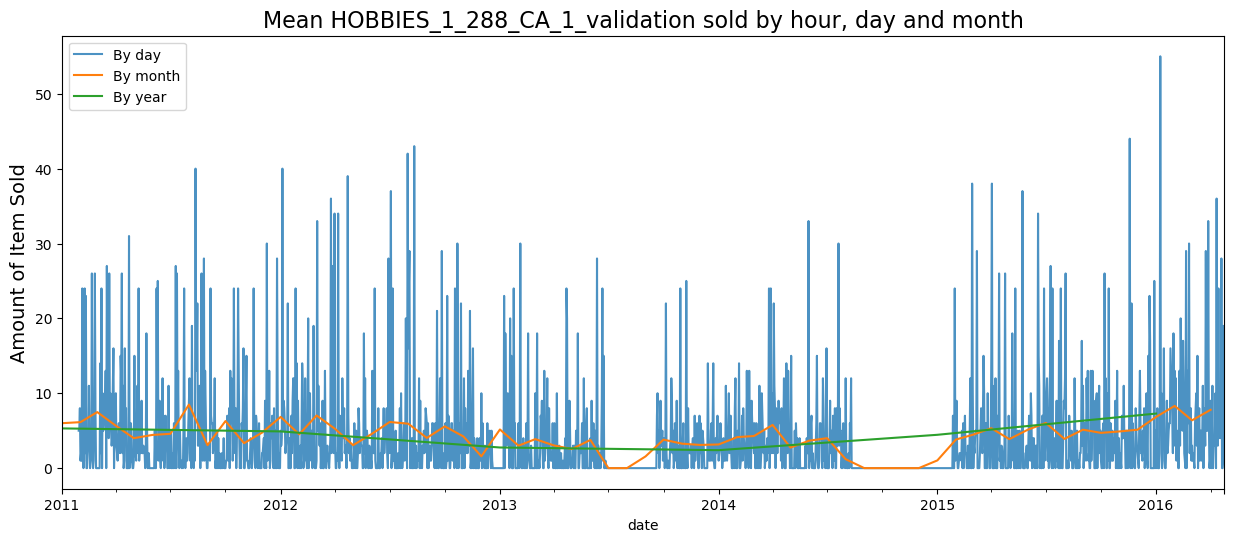

In [358]:
plot_item('HOBBIES_1_288_CA_1_validation')

Well, in this case, this particular item has been around from beginning till end, but did observe a complete hault in the middle. These unexpected fluctuations will surely skew our models. We will have to fix these later.

Now that we have a function that plots the selling history of an item, let's look at them from a categorical perspective; Let's sum these items by category to better understand which category of items have high volume of sales.

In [206]:
def agg_plot(*args):
    '''Plot the selling history of items aggregated by categories.
    
    Args:
        category(str): item(s) type as described by the id column (i.e. HOBBIES, HOUSEHOLD, FOODS).
    
    Returns:
        matplotlib plot object of category sale history
    '''
    temp = sales.copy()
    temp['item_cat'] = temp['id'].str.split('_',1).str.get(0).str.lower()
    
    if len(args)==1:
        cat_df = temp[temp['item_cat']==args[0]][d_cols]
        cat_totals = cat_df.sum(axis=0).T

        cat_totals.plot(figsize=(14,10), title = str(args[0])+'_aggregated', color = next(colors))
        plt.legend('')
        plt.show()

    else:
        aggs = []
        for i in args:
            cat_df = temp[temp['item_cat']==i][d_cols]
            aggs.append(np.asarray(cat_df.sum(axis=0).T))
        plt.figure(figsize=(14,10))
        for x in aggs:
            vis = plt.plot(x)
            vis = plt.xlabel('Day Sold')
            vis = plt.ylabel('Amount of Items Sold')
            vis = plt.title('Total Items Sold by Category')
        plt.legend([i for i in args])
        plt.show()

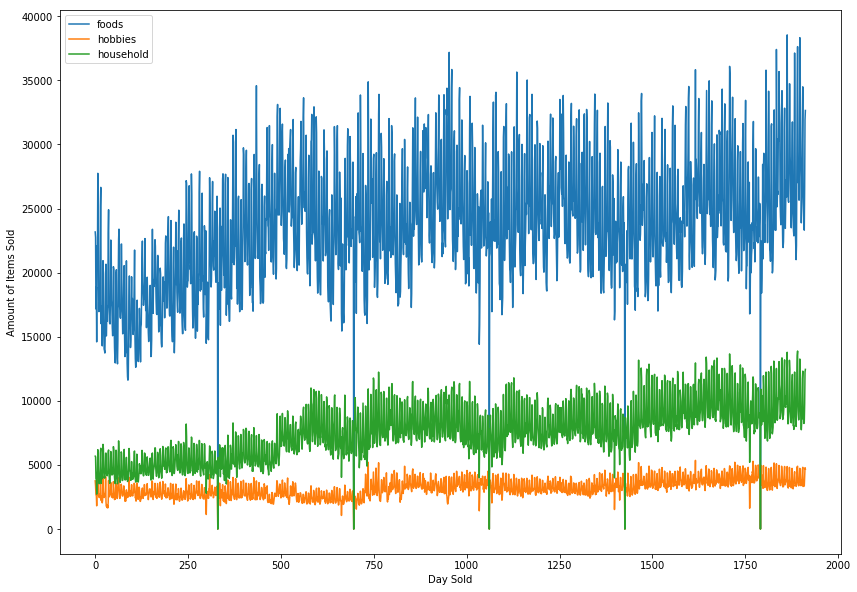

In [207]:
agg_plot('foods','hobbies','household')

We can see that Food items are sold consistantly more often than the other categories. On the other hand, even though items in hobbies are sold less frequently, the series is much less noisy than the other categories. The categories seem to have very similar seasonal/cyclical fluctuations; no lead/lag relationship.

Let's reduce the number of categories to see if we can index on any trends. Reducing the categories will reduce the y axis range, so trends should be more pronounced.

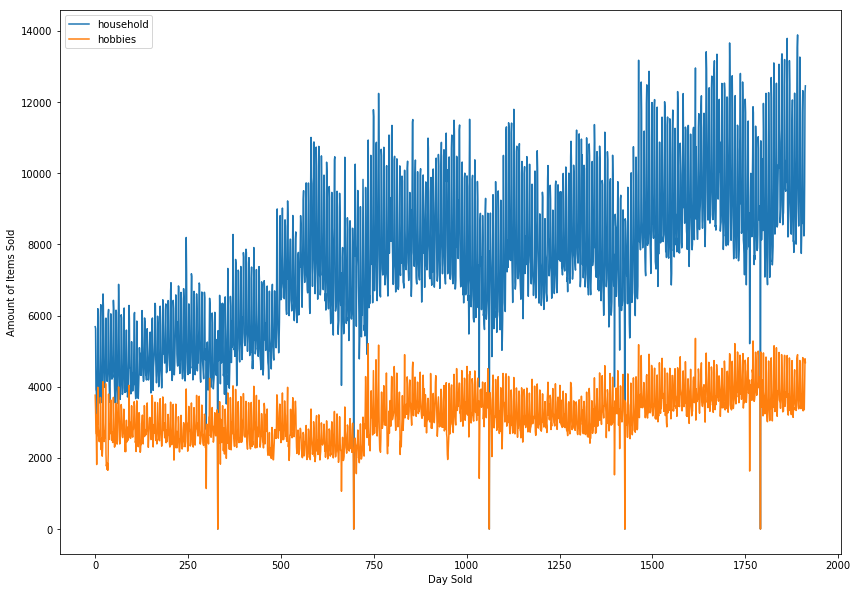

In [214]:
agg_plot('household', 'hobbies')

We can see that 'household' has a moderate upwards trend, whereas 'hobbies' consolidates in the 3,000/low 4,000 items per day range.

Given the hierarchical nature of the data, lets graph the selling history of these items by store id.

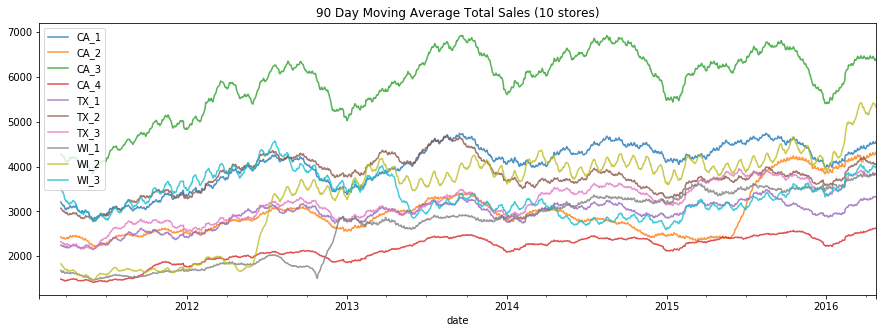

In [415]:
##Thanks to https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration for providing this.

past_sales = sales.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = prices['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(50).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='90 Day Moving Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Based on the behavior of some of the stores, we should prioritize 'CA_3' which sells much more than the other stores, and then 'WI_1', 'WI_2', and 'CA_2' which observe abnormal spikes at some point in the time series.

Text(0, 0.5, 'Amount of Items')

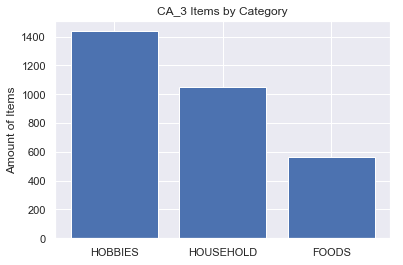

In [591]:
d_c = ['cat_id']+d_cols
ca3_cats = sales.loc[sales['store_id']=='CA_3'][d_c]
plt.bar(ca3_cats['cat_id'].unique(), height=ca3_cats['cat_id'].value_counts())
plt.title('CA_3 Items by Category')
plt.ylabel('Amount of Items')

Since we know that CA_3 sells much more than the other stores, let's plot the proportion they sell relative to total items sold.

Text(0, 0.5, 'Percentage of CA_3')

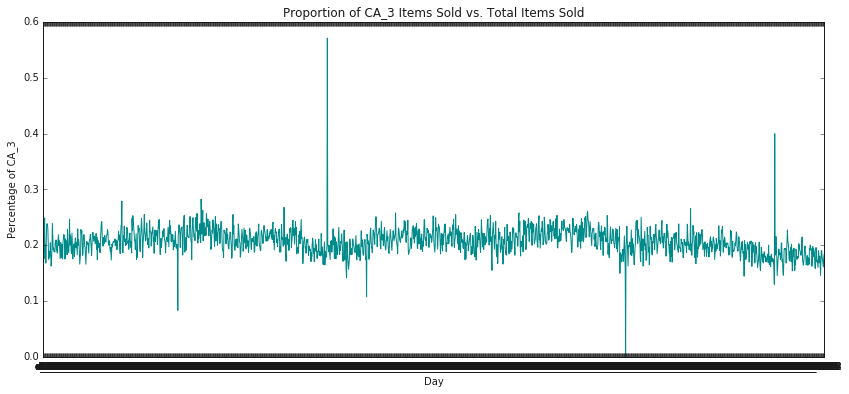

In [649]:
ca3_totals = ca3_cats[d_cols].sum(axis=0)

non_ca3_cats = sales.loc[sales['store_id']!='CA_3'][d_cols].sum(axis=0)
non_ca3_cats.head()

plt.figure(figsize = (14,5))
plt.plot((ca3_totals/non_ca3_cats), color = 'darkcyan')
plt.title('Proportion of CA_3 Items Sold vs. Total Items Sold')
plt.xlabel('Day')
plt.ylabel('Percentage of CA_3')

Wow! The store seeems to sell, on average, about 20% of the stores total items. The store must be huge.

In [623]:
def store_by_cat(store):
    '''Plot the selling history of the specified store by category.
    
    Args:
        store(str): id of the store we are wanting to plot.
    
    Returns:
        matplotlib plot object of item sale history by category
    '''
    d_c = ['cat_id']+d_cols
    store_cats = sales.loc[sales['store_id']==store][d_c]
    
    plt.box('off')
    plt.figure(figsize=(14,5))
    for x in store_cats['cat_id'].unique():
        cat_df = store_cats[store_cats['cat_id']==x][d_cols].sum(axis=0).T
        cat_df = cat_df.rolling(100).mean()
        vis = plt.plot(cat_df)
        vis = plt.xlabel('Day Sold')
        vis = plt.ylabel('Amount of Items Sold')
        vis = plt.title('100-day Moving Average of %s Amount of Items Sold by Category' % (store))
    plt.legend([x for x in store_cats['cat_id'].unique()])
    plt.show()

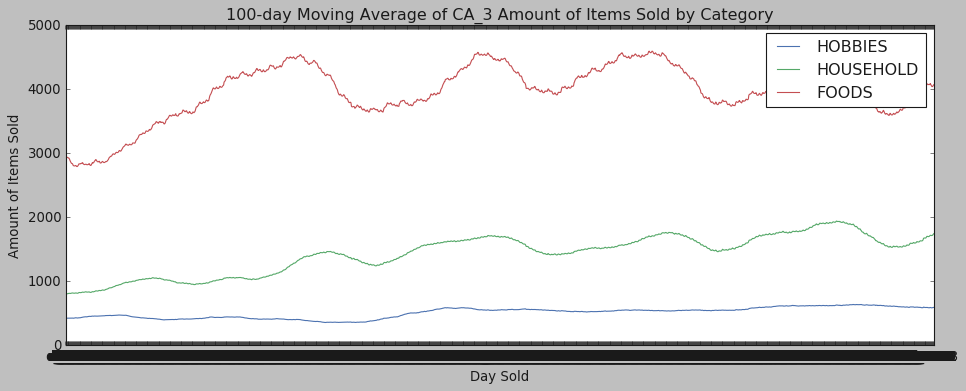

In [624]:
store_by_cat('CA_3')

Based on the graph, it looks like this particular store sells much more food items than the average store, and a little more household items.

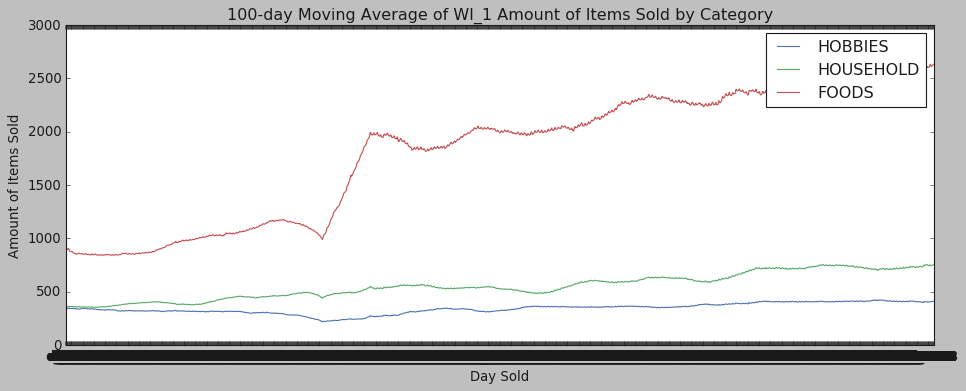

In [625]:
store_by_cat('WI_1')

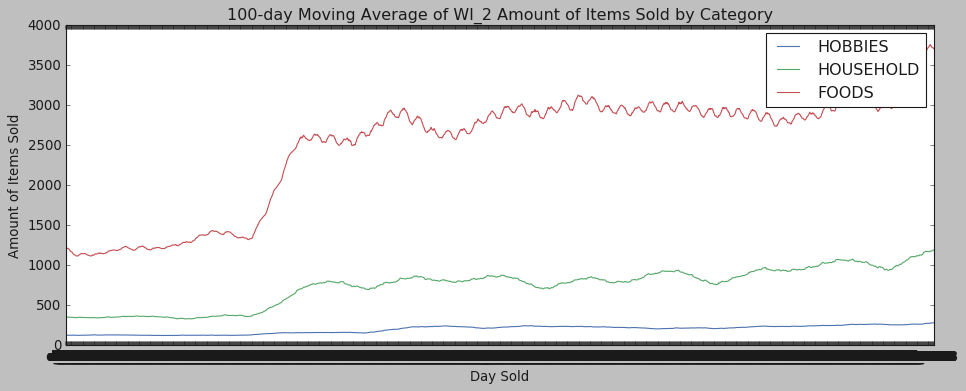

In [626]:
store_by_cat('WI_2')

Both of the above WI stores observed a huge jump in food sales early on the series. Considering the success in food sales in the other stores, it looks like these stores adopted the business model of prioritizing food items.

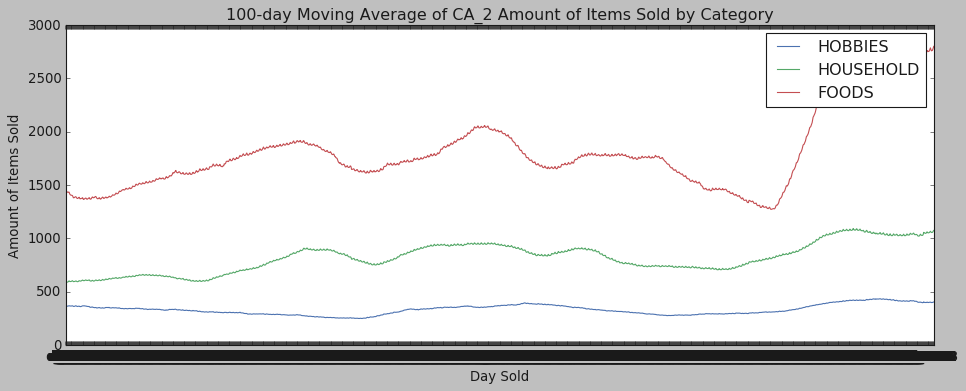

In [627]:
store_by_cat('CA_2')

Like the above WI stores, this CA store made a huge jump in food sales.

On average, the stores located in CA seem to sell more than the stores in the other states. Let's create a similar graph that index the selling history by state, not just by store.

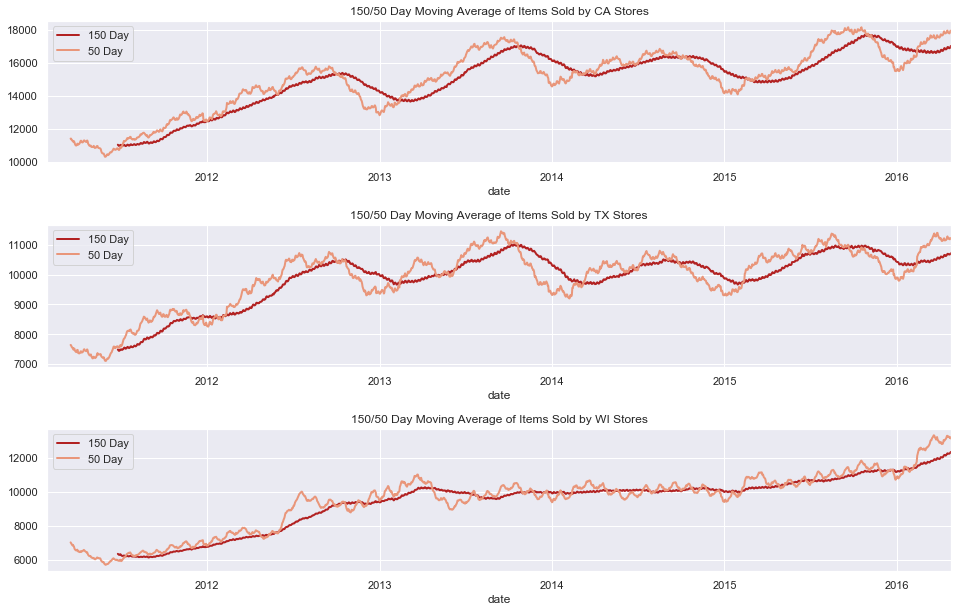

In [519]:
'''Plotting the 150/50 Day Moving Average of Items Sold by State'''

state_list = sales['state_id'].unique()

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(14, 9))
axes = (ax1,ax2,ax3)
fig.tight_layout(pad=3.0)

for s in range(len(state_list)):
    store_items = [c for c in past_sales.columns if state_list[s] in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(150).mean() \
        .plot(kind='line',
          title='150/50 Day Moving Average of Items Sold by {} Stores'.format(state_list[s]),
          lw=2,
          color='firebrick',
          ax= axes[s])
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(50).mean() \
        .plot(kind='line',
          title='150/50 Day Moving Average of Items Sold by {} Stores'.format(state_list[s]),
          lw=2,
          color= 'darksalmon',
          ax=axes[s]
        )
    axes[s].legend(['150 Day', '50 Day'], loc='upper left')
 

Though all states are slightly trending upwards, it is clear that CA maintains a higher selling range than TX and WI.

Now that we've observed the selling history by state, Lets observe the prices of the items - grouped by category - in a violin plot.

Text(0.5, 1.0, 'Item Sale Price by Item Category for Each State')

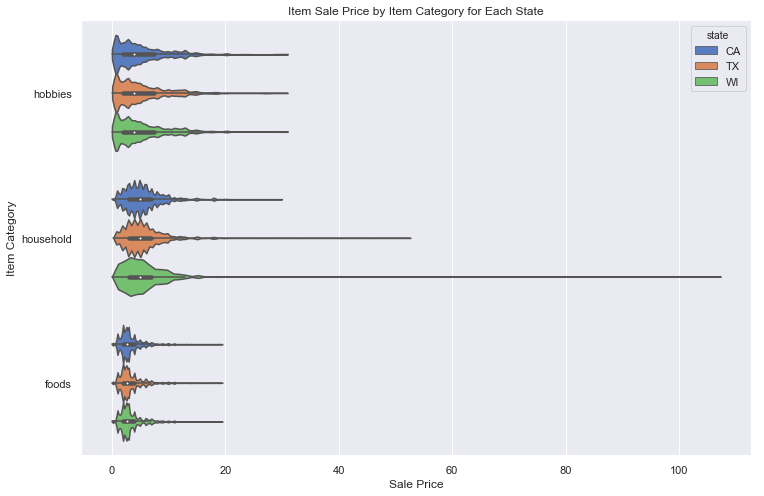

In [512]:
import seaborn as sns

temp = prices.copy()
temp['item_cat'] = temp['item_id'].str.split('_',1).str.get(0).str.lower()
temp['state'] = temp['store_id'].str.split('_').str.get(0)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(style ='darkgrid')
sns.violinplot(x=temp['sell_price'],y=temp['item_cat'], hue=temp['state'], ax = ax, scale='width', cut=0, palette='muted')
ax.set_xlabel('Sale Price')
ax.set_ylabel('Item Category')
ax.set_title('Item Sale Price by Item Category for Each State')

What we can gather from this is that food items cost the least and, in general, household items and hobby items cost the same on average -- withstanding a few household items that blow up the price range. Additionally, based on the graph, the stores sell the same items regardless of state; the only exception to this is that it seems that WI and TX sell a few more expensive items that CA doesn't sell.

It's important to take into account the sales during holidays. Lets gather this information.

In [515]:
#credit: https://www.kaggle.com/williamhuybui/holiday-s-visualization

#List of all events
event_list=[i for i in cal.event_name_1.fillna(0).unique() if i != 0] 

#Extract all the days an event has in the span of 1916 days
day_event_list=[cal[cal.event_name_1==i].d.tolist() for i in event_list]

#Create the Event_df dataframe which we will use throughout the notebook
event_df=pd.DataFrame({'Event Name' : event_list, 'Event day':day_event_list})
restricted_day= set(['d_'+ str(i) for i in np.arange(1916,1970)])
quantity=[]

for i in day_event_list:
    # Making sure that we exclude all the days thats are not in the training set
    clean_i=list(set(i)-restricted_day)
    temp=sales[clean_i].sum().sum() #Adding columns and then rows
    quantity.append(temp)

event_df['Quantity']=quantity
event_df

,Event Name,Event day,Quantity
0,SuperBowl,"[d_9, d_373, d_737, d_1101, d_1465, d_1836]",245544
1,ValentinesDay,"[d_17, d_382, d_748, d_1113, d_1478, d_1843]",200974
2,PresidentsDay,"[d_24, d_388, d_752, d_1116, d_1480, d_1844]",206678
3,LentStart,"[d_40, d_390, d_747, d_1132, d_1482, d_1839]",184362
4,LentWeek2,"[d_47, d_397, d_754, d_1139, d_1489, d_1846]",178482
5,StPatricksDay,"[d_48, d_414, d_779, d_1144, d_1509, d_1875]",200758
6,Purim End,"[d_51, d_405, d_758, d_1143, d_1497, d_1882]",215742
7,OrthodoxEaster,"[d_86, d_443, d_828, d_1535, d_1920]",153108
8,Pesach End,"[d_88, d_442, d_795, d_1180, d_1534, d_1919]",167251
9,Cinco De Mayo,"[d_97, d_463, d_1193, d_1558, d_1924]",131294


In [516]:
#Top 2 and bottom 2 in terms of total sales
a=event_df.sort_values('Quantity',ascending=False)[['Event Name','Quantity']].head(2)
b=event_df.sort_values('Quantity',ascending=False)[['Event Name','Quantity']].tail(3)
a.append(b)

,Event Name,Quantity
0,SuperBowl,245544
6,Purim End,215742
26,NewYear,128842
23,Thanksgiving,105650
24,Christmas,78


We've just grabbed the top and bottom values in terms of items sold. It looks like, wth exception to Christmas, even the worst performing holidays still do a good job in Sales. Christmas is the only day where we see a huge deviation from holiday sales.

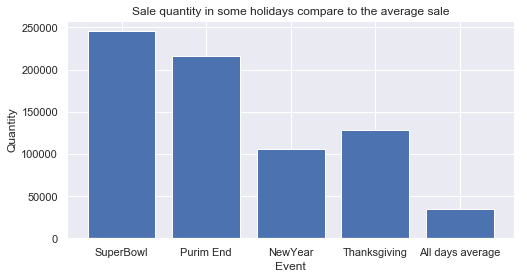

In [518]:
average_quantity=sales.iloc[:,6:].sum().sum()/1913
name=['SuperBowl','Purim End','NewYear','Thanksgiving', 'All days average']
values=event_df[event_df['Event Name'].isin(name)].Quantity.tolist()
values.append(average_quantity)


plt.figure(figsize=(8,4))
plt.xlabel("Event")
plt.ylabel("Quantity")
plt.bar(name,values)
plt.title("Sale quantity in some holidays compare to the average sale")
plt.show()

As shown in the graph, even though New Year and Thanksgiving rank among the worst selling holidays, they still perform better than the average day. Once again, the only exception we observe is Christmas.

In [659]:
prices[prices['item_cat']=='FOODS'][['sell_price']].describe().loc[['max', 'min']]

,sell_price
max,19.48
min,0.01


In [660]:
prices[prices['item_cat']=='HOBBIES'][['sell_price']].describe().loc[['max', 'min']]

,sell_price
max,30.98
min,0.01


In [661]:
prices[prices['item_cat']=='HOUSEHOLD'][['sell_price']].describe().loc[['max', 'min']]

,sell_price
max,107.32
min,0.01


In [657]:
prices['item_cat'] = prices['item_id'].str.split('_').str.get(0)
avg_price_per_cat = prices.groupby('item_cat')[['sell_price']].mean()

In [658]:
avg_price_per_cat

,sell_price
item_cat,
FOODS,3.251027
HOBBIES,5.333896
HOUSEHOLD,5.465780


In [656]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
